In [1]:
# CNN(Convolutional Neural Network) - Fashion MNIST Dataset

# 딥러닝 CNN 아키텍처 
# Feature Extractor(Conv>Pool>Conv>Pool) -> Fully-Connected(Flatten) -> Classification(Linear>Dropout->Linear)
# 학습
# - StepLR : 일정 에폭마다 학습률을 감소시킨다.
# - EarlyStopping : 일정 에폭 동안 성능 향상이 없을 경우 학습을 조기 중단, 과적합 방지, 학습 시간 절약
# 시각화
# - confusion_matrix(혼돈 행렬), classification_report

In [ ]:
# 1) import, GPU 설정
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('pytorch version : ', torch.__version__, ', device : ', DEVICE)

# 입력 이미지 크기가 고정되어 있을 때, PyTorch가 여러 가지 알고리즘 중에서 가장 빠른 Convolution 알고리즘을 자동으로 선택
# - benchmark = True로 설정하면, 처음 몇 번의 실행에서 다양한 알고리즘을 테스트한 뒤 가장 빠른 알고리즘을 캐싱해서 계속 사용한다.
# - 특히 CNN에서 Conv2D, MaxPool2D 같은 연산이 반복될 때 큰 속도 향상이 있다.
torch.backends.cudnn.benchmark = True

pytorch version :  2.7.1+cu118 , device :  cuda


In [3]:
# 2) FASHION MNIST Dataset 다운로드

# transform 전처리 - Fashion MNIST의 픽셀 값은 01로 변환 후 평균 0.5, 표준편차 0.5로 정규화
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize( (0.5,), (0.5) )
])

# train
train_dataset = datasets.FashionMNIST(root='./data/FashionMNIST_data',
                               train=True,
                               transform=transform,
                               download=True)
# test
test_dataset = datasets.FashionMNIST(root='./data/FashionMNIST_data',
                               train=False,
                               transform=transform,
                               download=True)

In [4]:
# FASHION MNIST Dataset 확인
print(len(train_dataset), len(test_dataset))

60000 10000


In [5]:
# 3) FASHION MNIST Dataset 데이터 분리 - train 85% : validation 15%
train_dataset_size = int(len(train_dataset) * 0.85) # train 85%
# validation_dataset_size = int(len(train_dataset) * 0.15) # validation 15%
validation_dataset_size = len(train_dataset) - train_dataset_size # validation 15%

# 데이터셋을 지정된 비율로 무작위 분할
train_dataset, validation_dataset = random_split(dataset=train_dataset, # 원본 데이터셋 여기서는 Fashion MNIST의 학습 데이터 전체를 의미
                                                 lengths=[train_dataset_size, validation_dataset_size], # lengths 인자에 각 부분의 크기를 리스트로 전달, 예)전체가 60,000개라면 train_dataset_size = 51,000, validation_dataset_size = 9,000
                                                 generator=torch.Generator().manual_seed(42)) # - 무작위 분할의 재현성을 보장, manual_seed(42)를 설정하면, 매번 실행해도 동일한 방식으로 데이터를 나눈다.


In [6]:
# FASHION MNIST Dataset 데이터 분리 확인
print(len(train_dataset), len(validation_dataset), len(test_dataset))

51000 9000 10000


In [7]:
# 4) batch, dataloader 생성
BATCH_SIZE = 32

# train
train_dataset_loader = DataLoader(dataset=train_dataset,
                                  batch_size=BATCH_SIZE,
                                  shuffle=True)

# validation
validation_dataset_loader = DataLoader(dataset=validation_dataset,
                                  batch_size=BATCH_SIZE,
                                  shuffle=False)

# test
test_dataset_loader = DataLoader(dataset=test_dataset,
                                  batch_size=BATCH_SIZE,
                                  shuffle=False)

{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


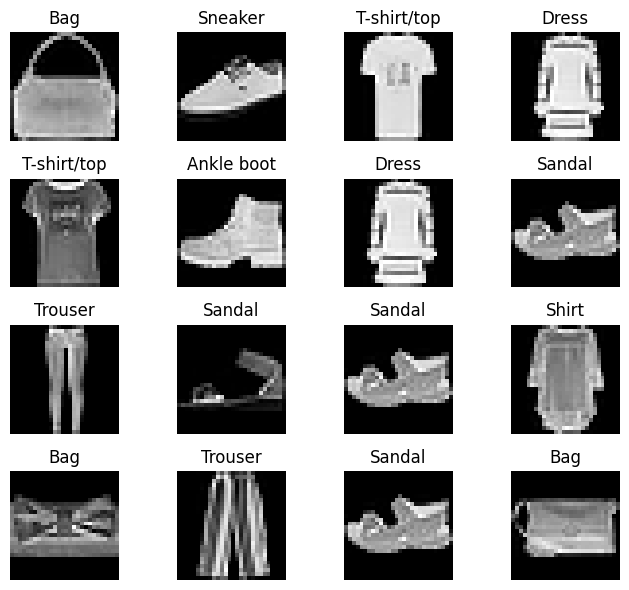

In [8]:
# 5) 베치 시각화 및 라벨 확인 

# MNIST Dataset 1개 배치 데이터 확인
images, labels = next(iter(train_dataset_loader))

# labels map 생성
# labels_map = { v:k for k, v in train_dataset.dataset.class_to_idx.items() }
labels_map = dict(enumerate(datasets.FashionMNIST.classes))
print(labels_map)

plt.figure(figsize=(7,6))
cols, rows = 4, 4

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1,)).item()
    img, label = images[sample_idx], labels[sample_idx].item()
    
    plt.subplot(cols, rows, i)
    plt.title(labels_map[label])
    plt.imshow(torch.permute(img, (1,2,0)), cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:
# 6) CNN Model
# 딥러닝 CNN 아키텍처
# Feature Extractor(Conv>Pool>Conv>Pool) -> Fully-Connected(Flatten) -> Classification(Linear>Dropout->Linear)
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)        
        self.pooling = nn.MaxPool2d(kernel_size=2, stride=2)        
        self.fc1 = nn.Linear(7 * 7 * 64, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout25 = nn.Dropout(p=0.25)
        self.dropout50 = nn.Dropout(p=0.5)
        self.bn1 = nn.BatchNorm2d(32) # BatchNorm2d를 추가하면 일반화 성능 향상 가능
        self.bn2 = nn.BatchNorm2d(64)
        self.act = nn.LeakyReLU(0.01) # LeakyReLU는 음수 입력에 대해 아주 작은 기울기(예: 0.01)를 유지, 이렇게 하면 뉴런이 완전히 죽지 않고, 미세하게라도 학습에 참여할 수 있다.

    
    def forward(self, x):
        # 패딩이 적용되었기 때문에 컨볼루션층을 통과한 데이터는 크기는 변하지 않고 필터 개수와 동일하게 출력채널 개수만 변함, 맥스풀링층을 통과한 데이터는 1/2로 바뀌지만 채널 개수는 변하지 않음
        # conv1, data shape = (H, W, C) = (28, 28, 1)
        x = self.bn1(self.conv1(x)) # (28, 28, 1)
        # x = torch.relu(x) # (28, 28, 32)
        x = self.act(x)
        x = self.pooling(x) # (28, 28, 32)
        x = self.dropout25(x) # (14, 14, 32)
        # conv2
        x = self.bn2(self.conv2(x)) # (14, 14, 32)
        # x = torch.relu(x) # (14, 14, 64)
        x = self.act(x)
        x = self.pooling(x) # (14, 14, 64)
        x = self.dropout25(x) # (7, 7, 64)
        # (높이,너비,채널)3차원 텐서이므로 완전연결층(Fully-Connected)과 연결을 위해 view() 명령어를 이용해서 3차원 텐서를 1차원 vector로 만들어 주는 역할
        # 여기서 -1은 PyTorch에게 "배치 크기는 자동으로 계산해줘"라는 의미, 7 * 7 * 64는 Conv 레이어를 통과한 후의 feature map 크기를 하드코딩한 것이다.
        # x = x.view(-1, 7 * 7 * 64) # 이 방식은 입력 이미지가 항상 28×28이고, Conv 구조가 고정되어 있을 때만 잘 작동, 단점: 만약 이미지 크기나 Conv 구조가 바뀌면 오류 발생 가능성이 높습니다.
        
        # x.size(0)은 현재 배치 크기를 의미, -1은 나머지 모든 차원을 자동으로 펼쳐서 1차원 벡터로 만들어준다., 장점: 유연하고, 재사용 가능한 모델 구조를 만들 수 있다.
        # 예시) x.shape = [32, 64, 7, 7]
        # x.view(-1, 3136)         # 하드코딩 방식
        # x.view(x.size(0), -1)    # 자동 계산 방식 → 32 × 3136
        x = x.view(x.size(0), -1)

        # Linear
        x = self.fc1(x)
        # x = torch.relu(x)
        x = self.act(x)
        x = self.dropout50(x)
        
        x = self.fc2(x)

        return x

In [10]:
# 7) EarlyStopping 클래스 정의
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001): # min_delta를 0.0으로 설정하면 아주 미세한 개선도 인정되지 않으므로, 0.001 정도로 설정하면 더 현실적인 중단 조건이 된다.
        self.patience = patience # 개선되지 않아도 기달릴 에폭 수
        self.min_delta = min_delta # 개선으로 간주할 최소 변화량
        self.best_loss = float('inf') # 가장 낮은 validation loss
        self.counter = 0 # 개선되지 않는 에폭 수
        self.early_stop = False # 중단 여부
    
    def __call__(self, val_loss):
        # 매 에폭마다 validation loss를 받아서 개선 여부를 판단한다.
        # val_loss < self.best_loss - self.min_delta 이면 개선된 것으로 간주한다.
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        # 그렇지 않으면 counter를 증가시키고, counter가 patience 이상이면 early_stop을 True로 설정해 학습 중단 신호를 보낸다.
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [11]:
# 8) Model 객체 생성
model = CNNModel().to(DEVICE)

# loss function
loss_function = nn.CrossEntropyLoss() # Softmax() 함수 포함되어 있음

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# StepLR 스케줄러 정의
scheduler = StepLR(optimizer, step_size=3, gamma=0.5) # 5 에폭마다 학습률을 절반으로 감소하지만, 전체 에폭 수가 적다면 step_size=3 정도로 조정한다.

# Model 정보
print(model)

CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (dropout25): Dropout(p=0.25, inplace=False)
  (dropout50): Dropout(p=0.5, inplace=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): LeakyReLU(negative_slope=0.01)
)


In [12]:
# 9) Model train 함수
def model_train(dataloader, model, loss_function, optimizer):
    model.train() # 확습모드

    train_loss_sum = 0
    train_correct = 0
    train_total = 0
    total_train_batch = len(dataloader)

    for images, labels in dataloader:
        # 처음 크기는 (batch_size, 1, 28, 28) -> (batch_size, 784) 1차원 벡터로 변환
        x_train = images.to(DEVICE)
        y_train = labels.to(DEVICE)

        # 모델 예측값 게산
        outputs = model(x_train)

        # 손실함수값 계산
        loss = loss_function(outputs, y_train)

        # 오차역전파
        optimizer.zero_grad() # 미분 연산 초기화
        loss.backward() # 미분 연산
        optimizer.step() # 미분 연산 후 가중치 바이어스 파라미터 업데이트

        train_loss_sum += loss.item()
        train_total += y_train.size(0)
        # train_correct += (torch.argmax(outputs, 1) == y_train).sum().item() # torch 모듈의 argmax() 함수를 호출하여 outputs 텐서에서 dim=1 기준으로 최대값의 인덱스를 반환
        train_correct += (outputs.argmax(dim=1) == y_train).sum().item() # outputs 텐서 객체의 메서드 .argmax()를 호출하여 dim=1 기준으로 최대값의 인덱스를 반환

    train_avg_loss = train_loss_sum / total_train_batch # 평균 오차 계산
    train_avg_accuracy = 100 * train_correct / train_total # 평균 정확도 계산

    return train_avg_loss, train_avg_accuracy

In [13]:
# 10) Model evaluate 함수
def model_evaluate(dataloader, model, loss_function):
    model.eval() # 추론모드

    with torch.no_grad(): # 미분 연산 하지 않음
        val_loss_sum = 0
        val_correct = 0
        val_total = 0
        total_val_batch = len(dataloader)

        for images, labels in dataloader:
            # 처음 크기는 (batch_size, 1, 28, 28) -> (batch_size, 784) 1차원 벡터로 변환
            x_val = images.to(DEVICE)
            y_val = labels.to(DEVICE)

            # 모델 예측값 게산
            outputs = model(x_val)

            # 손실함수값 계산
            loss = loss_function(outputs, y_val)

            val_loss_sum += loss.item()
            val_total += y_val.size(0)
            # val_correct += (torch.argmax(outputs, 1) == y_val).sum().item() # torch 모듈의 argmax() 함수를 호출하여 outputs 텐서에서 dim=1 기준으로 최대값의 인덱스를 반환
            val_correct += (outputs.argmax(dim=1) == y_val).sum().item() # outputs 텐서 객체의 메서드 .argmax()를 호출하여 dim=1 기준으로 최대값의 인덱스를 반환
            
        val_avg_loss = val_loss_sum / total_val_batch # 평균 오차 계산
        val_avg_accuracy = 100 * val_correct / val_total # 평균 정확도 계산

        return val_avg_loss, val_avg_accuracy

In [14]:
# 11) Model test 함수
def model_test(dataloader, model):
    model.eval() # 추론모드

    with torch.no_grad(): # 미분 연산 하지 않음
        test_loss_sum = 0
        test_correct = 0
        test_total = 0
        total_test_batch = len(dataloader)

        for images, labels in dataloader:
            # 처음 크기는 (batch_size, 1, 28, 28) -> (batch_size, 784) 1차원 벡터로 변환
            x_test = images.to(DEVICE)
            y_test = labels.to(DEVICE)

            # 모델 예측값 게산
            outputs = model(x_test)

            # 손실함수값 계산
            loss = loss_function(outputs, y_test)

            test_loss_sum += loss.item()
            test_total += y_test.size(0)
            # test_correct += (torch.argmax(outputs, 1) == y_test).sum().item() # torch 모듈의 argmax() 함수를 호출하여 outputs 텐서에서 dim=1 기준으로 최대값의 인덱스를 반환
            test_correct += (outputs.argmax(dim=1) == y_test).sum().item() # outputs 텐서 객체의 메서드 .argmax()를 호출하여 dim=1 기준으로 최대값의 인덱스를 반환
            
        test_avg_loss = test_loss_sum / total_test_batch
        test_avg_accuracy = 100 * test_correct / test_total

        print('accuracy = ', test_avg_accuracy, ', loss = ', test_avg_loss)

In [15]:
# 12) 모델 전체 테스트셋 추론 및 오답 시각화

# 전체 테스트셋 추론 함수
def model_all_test(dataloader, model):
    model.eval() # 추론 모드

    all_preds = []
    all_labels = []
    all_images = []

    test_loss_sum = 0
    test_correct = 0
    test_total = 0
    total_test_batch = len(dataloader)

    with torch.no_grad(): # 미분 연산 하지 않음
        for images, labels in dataloader:
            images = images.to(DEVICE) # 입력 데이터
            labels = labels.to(DEVICE) # 정답 데이터

            outputs = model(images) # 모델 예측
            _, preds = torch.max(outputs, dim=1) # 모델 예측값 추출

            all_preds.extend(preds.cpu().numpy()) # 예측값 넘파이로 변환 후 리스트 담는다.
            all_labels.extend(labels.cpu().numpy()) # 정답값 넘파이로 변환 후 리스트 담는다.
            all_images.extend(images.cpu())

            loss = loss_function(outputs, labels)
            test_loss_sum += loss.item()
            test_total += labels.size(0)
            # test_correct += (torch.argmax(outputs, 1) == labels).sum().item() # torch 모듈의 argmax() 함수를 호출하여 outputs 텐서에서 dim=1 기준으로 최대값의 인덱스를 반환
            test_correct += (outputs.argmax(dim=1) == labels).sum().item() # outputs 텐서 객체의 메서드 .argmax()를 호출하여 dim=1 기준으로 최대값의 인덱스를 반환

        test_avg_loss = test_loss_sum / total_test_batch
        test_avg_accuracy = 100 * test_correct / test_total
        
        print('accuracy = ', test_avg_accuracy, 'loss = ', test_avg_loss)
      
    # labels map 생성 - train_dataset 에서 정답 label map을 생성
    # labels_map = { v : k for k, v in train_dataset.dataset.class_to_idx.items() }
    labels_map = dict(enumerate(datasets.FashionMNIST.classes))

    # Confusion Matrix 시각화 -----------------------------------------------------------------
    cm = confusion_matrix(all_labels, all_preds) # Confusion Matrix 계산
    
    # 시각화
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=list(labels_map.values()), 
                yticklabels=list(labels_map.values()))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

     # Classification Report ----------------------------------------------------------------
     # precision(예측한 것 중에 실제로 맞춘 비율), recall(실제 정답 중에 얼마나 맞췄는지), f1-score(precision과 recall의 조화 평균), support(각 클래스의 샘플 수)
    report = classification_report(all_labels, all_preds, target_names=list(labels_map.values()))
    print('classification report:\n', report)

    # 오답 시각화 ------------------------------------------------------------------------------
    wrong_indices = [ i for i in range(len(all_preds)) if all_preds[i] != all_labels[i] ] # 오답 샘플 추출

    print('\n오답 시각화:')
    plt.figure(figsize=(10, 9))
    cols, rows = 5, 4

    for i in range(1, cols * rows + 1):
        if i > len(wrong_indices):
            break
        idx = wrong_indices[i - 1]
        # img = all_images[i].squeeze()
        img = all_images[idx].squeeze() # 오답 시각화에서 img = all_images[i].squeeze()는 idx = wrong_indices[i - 1]로 가져온 인덱스를 써야 정확하다.
        true_label = all_labels[idx]
        pred_label = all_preds[idx]

        plt.subplot(rows, cols, i)
        plt.imshow(img, cmap='gray')
        plt.title(f'T: {labels_map[true_label]}\nP: {labels_map[pred_label]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [16]:
# 13) Model 학습 
train_loss_list = []
train_accuracy_list = []

val_loss_list = []
val_accuracy_list = []

start_time = datetime.now()

EPOCHS = 20

# EarlyStopping 객체 생성
early_stopping = EarlyStopping(patience=5, min_delta=0.001)

for epoch in range(EPOCHS):
    # train
    train_avg_loss, train_avg_accuracy = model_train(dataloader=train_dataset_loader,
                                                     model=model,
                                                     loss_function=loss_function,
                                                     optimizer=optimizer)
    train_loss_list.append(train_avg_loss)
    train_accuracy_list.append(train_avg_accuracy)

    # evaluate
    val_avg_loss, val_avg_accuracy = model_evaluate(dataloader=validation_dataset_loader,
                                                     model=model,
                                                     loss_function=loss_function)
    val_loss_list.append(val_avg_loss)
    val_accuracy_list.append(val_avg_accuracy)

    # 학습률 스케줄러 업데이트
    scheduler.step()

    # print
    print(
        'epoch : ', '%02d' % (epoch + 1),
        'train loss = ', '{:4f}'.format(train_avg_loss), ', train acc = ', '{:4f}'.format(train_avg_accuracy),
        'val loss = ', '{:4f}'.format(val_avg_loss), ', val acc = ', '{:4f}'.format(val_avg_accuracy),
        'Current LR = ', scheduler.get_last_lr()[0] # 학습률 확인
    )

    # EarlyStopping 체크, 매 에폭마다 val_loss를 기준으로 중단 여부를 확인한다.
    early_stopping(val_avg_loss)
    if early_stopping.early_stop:
        print(f'Early stopping triggered at epoch {epoch + 1}')
        break

# time
end_time = datetime.now()
print('elapsed time => ', end_time -start_time)

epoch :  01 train loss =  0.534021 , train acc =  80.582353 val loss =  0.350724 , val acc =  87.411111 Current LR =  0.001
epoch :  02 train loss =  0.378086 , train acc =  86.337255 val loss =  0.292088 , val acc =  89.433333 Current LR =  0.001
epoch :  03 train loss =  0.329458 , train acc =  88.088235 val loss =  0.262492 , val acc =  90.388889 Current LR =  0.0005
epoch :  04 train loss =  0.275202 , train acc =  89.925490 val loss =  0.252640 , val acc =  90.755556 Current LR =  0.0005
epoch :  05 train loss =  0.263391 , train acc =  90.466667 val loss =  0.230732 , val acc =  91.644444 Current LR =  0.0005
epoch :  06 train loss =  0.249081 , train acc =  90.809804 val loss =  0.226941 , val acc =  91.611111 Current LR =  0.00025
epoch :  07 train loss =  0.227241 , train acc =  91.629412 val loss =  0.219669 , val acc =  92.155556 Current LR =  0.00025
epoch :  08 train loss =  0.213066 , train acc =  92.084314 val loss =  0.211096 , val acc =  92.366667 Current LR =  0.00025

In [17]:
# 14) Test Dataset 정확도, 오차 테스트
model_test(dataloader=test_dataset_loader,
            model=model)

accuracy =  92.71 , loss =  0.20941121089525117


accuracy =  92.71 loss =  0.20941121089525117


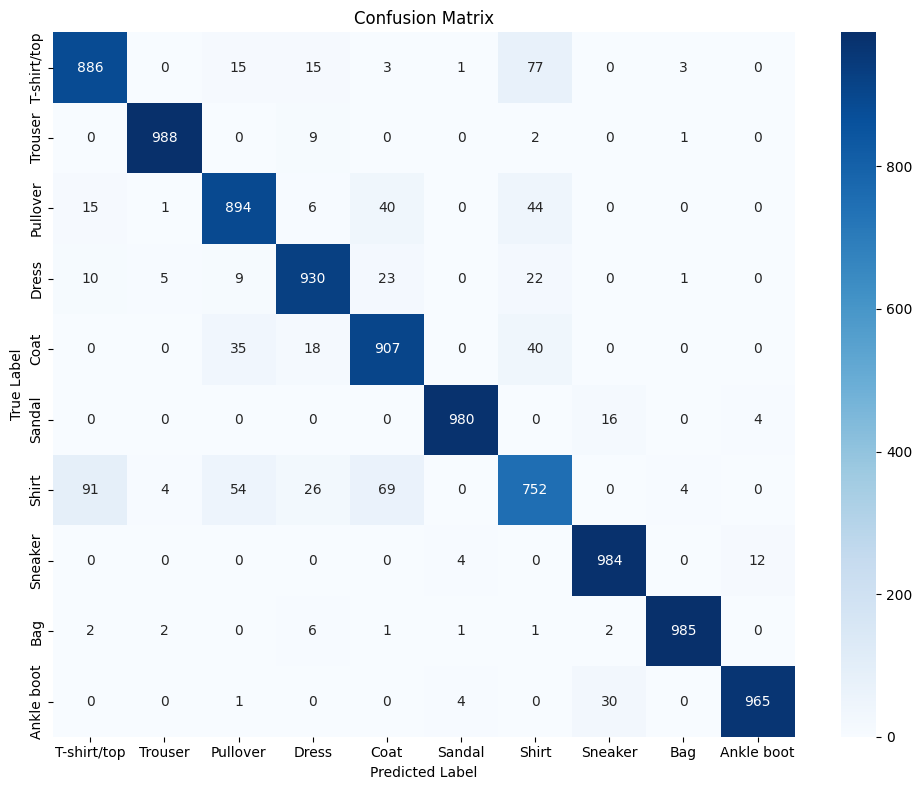

classification report:
               precision    recall  f1-score   support

 T-shirt/top       0.88      0.89      0.88      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.89      0.89      0.89      1000
       Dress       0.92      0.93      0.93      1000
        Coat       0.87      0.91      0.89      1000
      Sandal       0.99      0.98      0.98      1000
       Shirt       0.80      0.75      0.78      1000
     Sneaker       0.95      0.98      0.97      1000
         Bag       0.99      0.98      0.99      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000


오답 시각화:


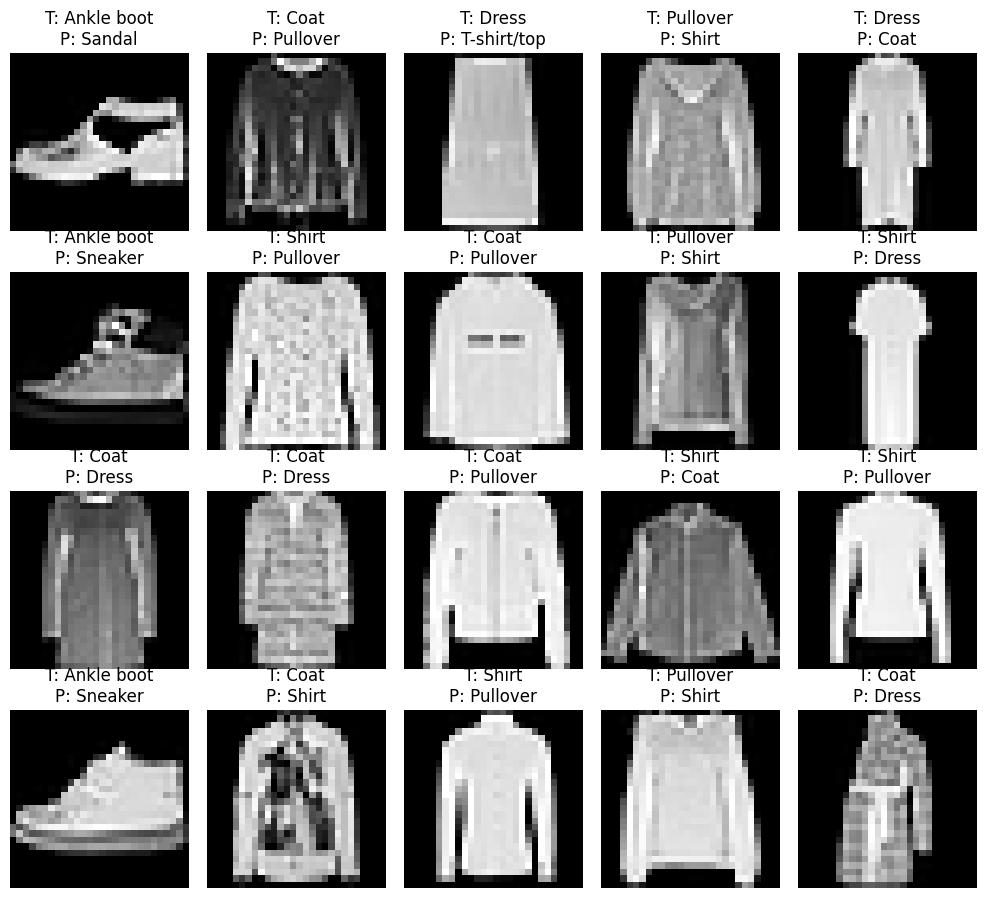

In [18]:
# 15) 모델 전체 테스트셋 추론 및 오답 시각화
model_all_test(dataloader=test_dataset_loader, model=model)

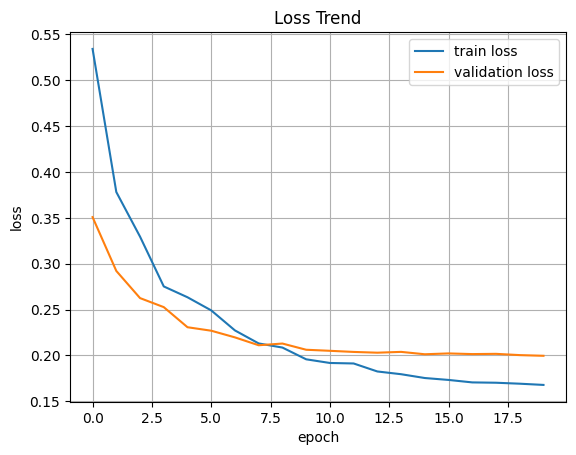

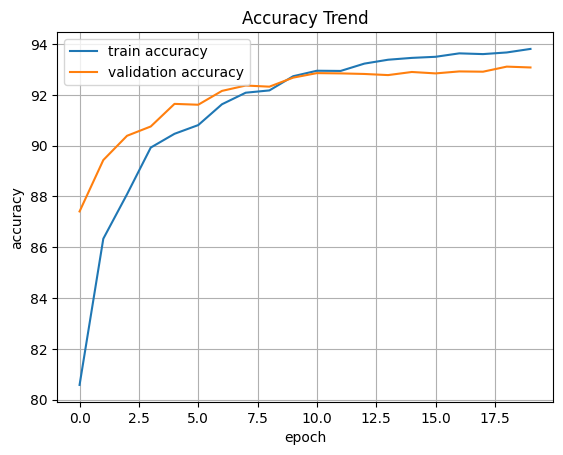

In [19]:
# 16) 시각화 - 손실함수
plt.title('Loss Trend')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_loss_list, label='train loss')
plt.plot(val_loss_list, label='validation loss')
plt.grid()
plt.legend(loc='best')
plt.show()

# 시각화 - 정확도
plt.title('Accuracy Trend')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(train_accuracy_list, label='train accuracy')
plt.plot(val_accuracy_list, label='validation accuracy')
plt.grid()
plt.legend(loc='best')
plt.show()


In [20]:
# 17) Save the model checkpoint
os.makedirs('./models', exist_ok=True)
# torch.save(model.state_dict(), './models/model_cnn_fashion_mnist.ckpt')

# 모델 저장 개선 형태로 저장 : 장시간 학습하거나, 실험을 반복할 때는 반드시 이 방식으로 저장
# - 모델 가중치, 옵티마이저 상태, 학습 진행 상황 (에폭, 손실 추세 등) 모두 저장
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch,
    'train_loss': train_loss_list,
    'val_loss': val_loss_list
}, './models/model_cnn_fashion_mnist.ckpt')

{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


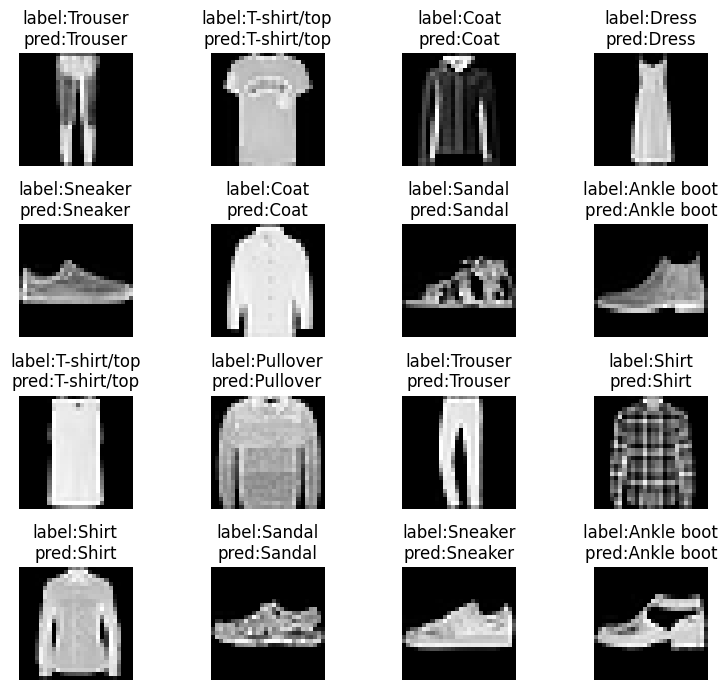

In [21]:
# 18) 단순 32개 샘플 테스트 - 모델 추론 및 예측값 추출
model = CNNModel().to(DEVICE)
# model.load_state_dict(torch.load('./models/model_cnn_fashion_mnist.ckpt'))

# 모델 로드 : 중단된 지점부터 이어서 학습
checkpoint = torch.load('./models/model_cnn_fashion_mnist.ckpt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1

BATCH_SIZE = 32

# test dataloader
test_image_loader = DataLoader(dataset=test_dataset,
                               batch_size=BATCH_SIZE,
                               shuffle=False)
# test dataset 1개 배치 추출
test_images, test_labels = next(iter(test_image_loader))

# 학습/정답 데이터
x_test = test_images.to(DEVICE)
y_test = test_labels.to(DEVICE)

# 모델 추론
outputs = model(x_test)

# 모델 예측값 추출
_, preds = torch.max(outputs, 1)

# labels map 생성 - train_dataset 에서 정답 label map을 생성
# labels_map = { v : k for k, v in train_dataset.dataset.class_to_idx.items() }
labels_map = dict(enumerate(datasets.FashionMNIST.classes))
print(labels_map)

sample_indices = torch.randperm(len(x_test))[:16] # 중복 없이 16개의 고유한 인덱스를 추출, 시각화할 때 같은 이미지가 반복되는 문제를 방지
# 시각화
plt.figure(figsize=(8, 7))
cols, rows = 4, 4

# for i in range(1, cols * rows + 1):
for i, idx in enumerate(sample_indices):
    img = test_images[idx]
    label = test_labels[idx].item()
    pred = preds[idx].item()

    plt.subplot(rows, cols, i + 1)

    # torch.randint()를 통한 1개의 index 추출
    # sample_idx = torch.randint(len(x_test), size=(1,)).item()    
    # test dataloder에서 image, label, pred 값을 추출하여 시각화 비교
    # img, label, pred = test_images[sample_idx], test_labels[sample_idx].item(), preds[sample_idx].item()

    plt.title('label:' + labels_map[label] + '\npred:' + labels_map[pred])
    plt.imshow(torch.permute(img, (1, 2, 0)), cmap='gray') # 본래 이미지 shape (3, 224, 224) -> 시각화 하기 위해서 (224, 224, 3) 변환
    plt.axis('off')
plt.tight_layout()
plt.show()